In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, models,util

In [92]:
data = pd.read_csv("cluster_article_tensor.csv")

In [111]:
cluster = data[data["cluster"]==20]

In [112]:
cluster = cluster.drop(["Unnamed: 0", "cluster", "article"],axis=1)

In [113]:
tensors = []
for i in range(cluster.shape[0]):
    tensor = [tensor for tensor in cluster.iloc[i,:]]
    tensors.append(tensor)

In [114]:
model = SentenceTransformer("fine_tuned_model_128")

In [115]:
sim_matrix = util.cos_sim(tensors, tensors)

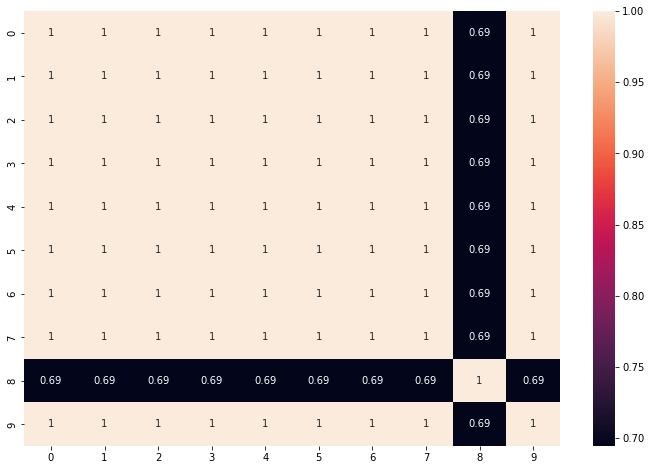

In [116]:
plt.figure(figsize=(12,8))
sns.heatmap(sim_matrix.numpy(),annot=True)
plt.show()